In [1]:
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
import networkx as nx
import matplotlib.pyplot as plt


# Functions for visualising graphing and checking coloring

In [2]:
def visualize_graph_coloring(adj_matrix, coloring):
    """
    Visualize the graph with its coloring.
    
    Parameters:
    - adj_matrix (numpy.ndarray): Adjacency matrix
    - coloring (numpy.ndarray): Coloring matrix (one-hot encoded)
    """
    G = nx.from_numpy_array(adj_matrix)
    
    # Determine the color for each node
    node_colors = []
    color_map = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'lime', 'pink']
    
    for i in range(len(adj_matrix)):
        for c in range(coloring.shape[1]):
            if coloring[i, c] == 1:
                node_colors.append(color_map[c % len(color_map)])
                break
        else:
            # If no color is assigned, use grey
            node_colors.append('grey')
    
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_weight='bold')
    plt.title("Graph Coloring Solution")
    plt.show()

def is_valid_coloring(adj_matrix, coloring):
    """
    Check if the coloring is valid.
    
    Parameters:
    - adj_matrix (numpy.ndarray): Adjacency matrix
    - coloring (numpy.ndarray): Coloring matrix
    
    Returns:
    - bool: True if valid, False otherwise
    """
    N = len(adj_matrix)
    
    # Check that each vertex has exactly one color
    for i in range(N):
        if np.sum(coloring[i, :]) != 1:
            return False
    
    # Check that no adjacent vertices have the same color
    for u in range(N):
        for v in range(N):
            if adj_matrix[u, v] == 1:
                for c in range(coloring.shape[1]):
                    if coloring[u, c] == 1 and coloring[v, c] == 1:
                        return False
    
    return True

# Make random Graph and validate coloring

In [3]:
# Generate a random graph
G = nx.erdos_renyi_graph(n=5, p=0.5, seed=55)  

# Compute graph coloring using NetworkX greedy algorithm
color_map = nx.coloring.greedy_color(G, strategy="largest_first")
num_colors = max(color_map.values()) + 1  # Number of colors used

# Create adjacency matrix (NxN)
adj_matrix = nx.to_numpy_array(G)

# Create coloring matrix (NxC)
coloring = np.zeros((len(G.nodes), num_colors))
for node, color in color_map.items():
    coloring[node, color] = 1

num_colors = coloring.shape[1]

In [4]:
is_valid_coloring(adj_matrix, coloring)

True

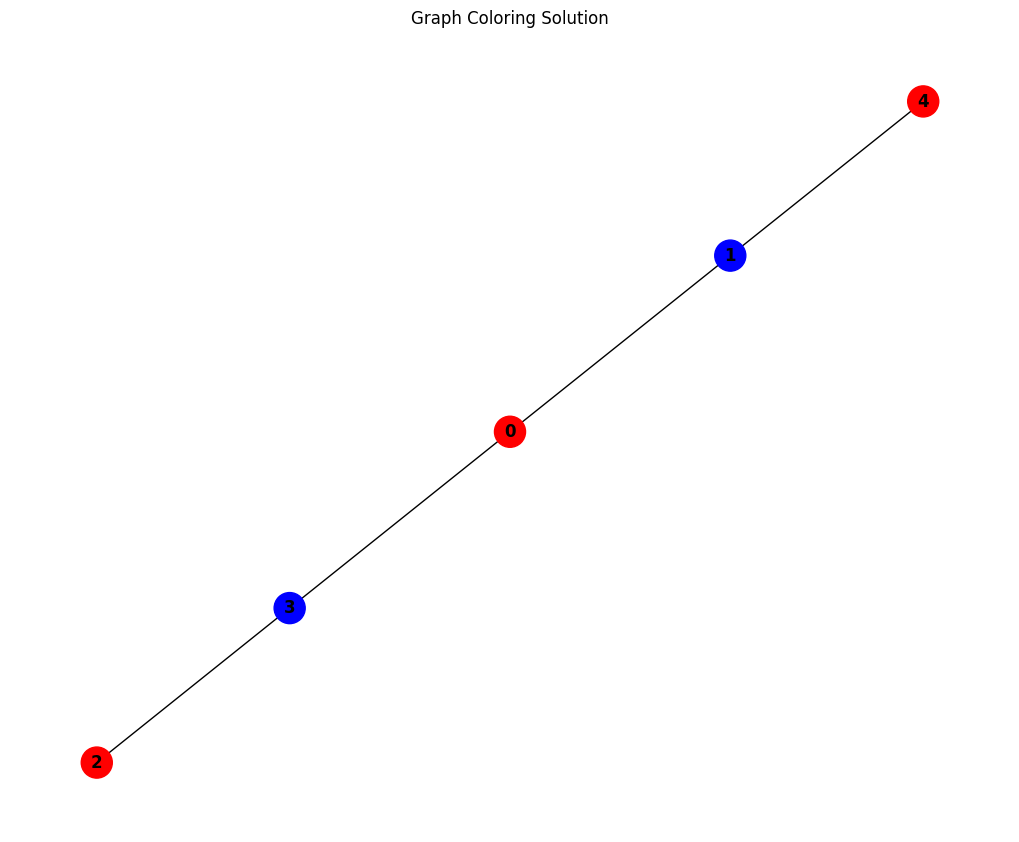

In [5]:
visualize_graph_coloring(adj_matrix, coloring)

# Energy Function

In [6]:
def graph_coloring_energy(adj_matrix, coloring, A=1):
    """
    Computes the energy function for a given graph coloring.

    Parameters:
    - adj_matrix (numpy.ndarray): Adjacency matrix of the graph (NxN).
    - coloring (numpy.ndarray): Coloring matrix (NxC), where C is the number of colors.
    - A (float): Penalty coefficient.

    Returns:
    - float: Energy value of the given coloring.
    """
    N, C = coloring.shape  # Number of vertices (N) and colors (C)

    # Term 1: Vertex Constraint - Each vertex should have exactly one color
    vertex_constraint = sum((1 - np.sum(coloring[i, :]))**2 for i in range(N))

    # Term 2: Edge Constraint - No two adjacent vertices should share the same color
    edge_constraint = sum(
        np.sum(coloring[u, :] * coloring[v, :])  # Sum over colors where both vertices have the same color
        for u in range(N) for v in range(N) if adj_matrix[u, v] == 1
    )

    # Compute total energy
    # print('\nvertex constraint')
    # print(vertex_constraint)
    # print('\nedge constraint')
    # print(edge_constraint)
    energy = A * (vertex_constraint + edge_constraint)
    
    return energy

# DSB

In [7]:
def compute_local_field(adj_matrix, q, A=1):
    """
    Compute the local field for DSB algorithm.
    
    Parameters:
    - adj_matrix (numpy.ndarray): Adjacency matrix of the graph
    - q (numpy.ndarray): Current binary state variables
    - A (float): Penalty coefficient
    
    Returns:
    - numpy.ndarray: Local field for each variable
    """
    N, C = q.shape
    
    # Initialize field
    h = np.zeros_like(q)
    
    # Vertex constraint contribution
    for i in range(N):
        sum_colors = np.sum(q[i, :])
        for c in range(C):
            h[i, c] += -2 * A * (1 - sum_colors)
    
    # Edge constraint contribution
    for u in range(N):
        for v in range(N):
            if adj_matrix[u, v] == 1:
                for c in range(C):
                    h[u, c] += A * q[v, c]
    
    return h

def discrete_simulated_bifurcation(adj_matrix, num_colors, max_iter=1000, dt=0.1, A=1, alpha_init=0.5, alpha_scale=0.998):
    """
    Optimize graph coloring using Discrete Simulated Bifurcation.
    
    Parameters:
    - adj_matrix (numpy.ndarray): Adjacency matrix of the graph
    - num_colors (int): Number of colors to use
    - max_iter (int): Maximum number of iterations
    - dt (float): Time step size
    - A (float): Penalty coefficient
    - alpha_init (float): Initial value of alpha
    - alpha_scale (float): Scaling factor for alpha each iteration
    
    Returns:
    - numpy.ndarray: Optimized coloring
    - list: Energy history
    """
    N = len(adj_matrix)  # Number of vertices
    
    # Initialize binary variables and their velocities
    q = np.random.choice([-1, 1], size=(N, num_colors))
    p = np.zeros((N, num_colors))
    
    # Initialize alpha (bifurcation parameter)
    alpha = alpha_init
    
    # Initialize energy history
    energy_history = []
    
    # Convert q to coloring (0/1 matrix)
    def q_to_coloring(q_matrix):
        coloring = np.zeros_like(q_matrix)
        coloring[q_matrix > 0] = 1
        return coloring
    
    # Main loop
    for iteration in range(max_iter):
        # Convert q to coloring format for energy calculation
        coloring = q_to_coloring(q)
        
        # Calculate current energy
        energy = graph_coloring_energy(adj_matrix, coloring, A)
        energy_history.append(energy)
        
        # Calculate local field
        h = compute_local_field(adj_matrix, coloring, A)
        
        # Update momentum (p)
        p = p - dt * h
        
        # Update position (q)
        for i in range(N):
            for c in range(num_colors):
                # Update using discrete simulated bifurcation equations
                if p[i, c] > 0:
                    q[i, c] = 1
                elif p[i, c] < 0:
                    q[i, c] = -1
                # If p[i, c] is exactly 0, q[i, c] remains unchanged
        
        # Decrease alpha (annealing)
        alpha *= alpha_scale
        
        # Check if solution is valid (termination condition)
        if energy == 0:
            break
    
    # Return the best coloring found
    final_coloring = q_to_coloring(q)
    return final_coloring, energy_history

# Running DSB

Final energy: 0.0000
Is valid coloring: True

Node colorings:
Node 0: Color 1
Node 1: Color 0
Node 2: Color 1
Node 3: Color 0
Node 4: Color 1


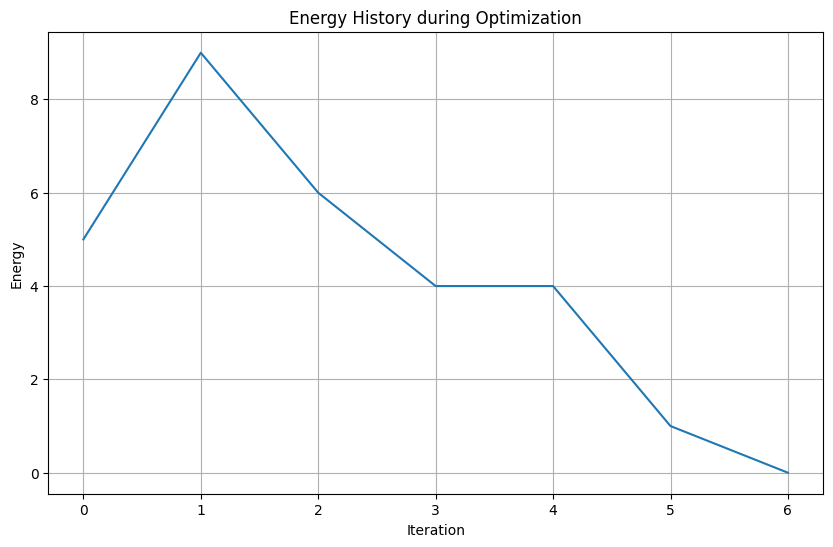

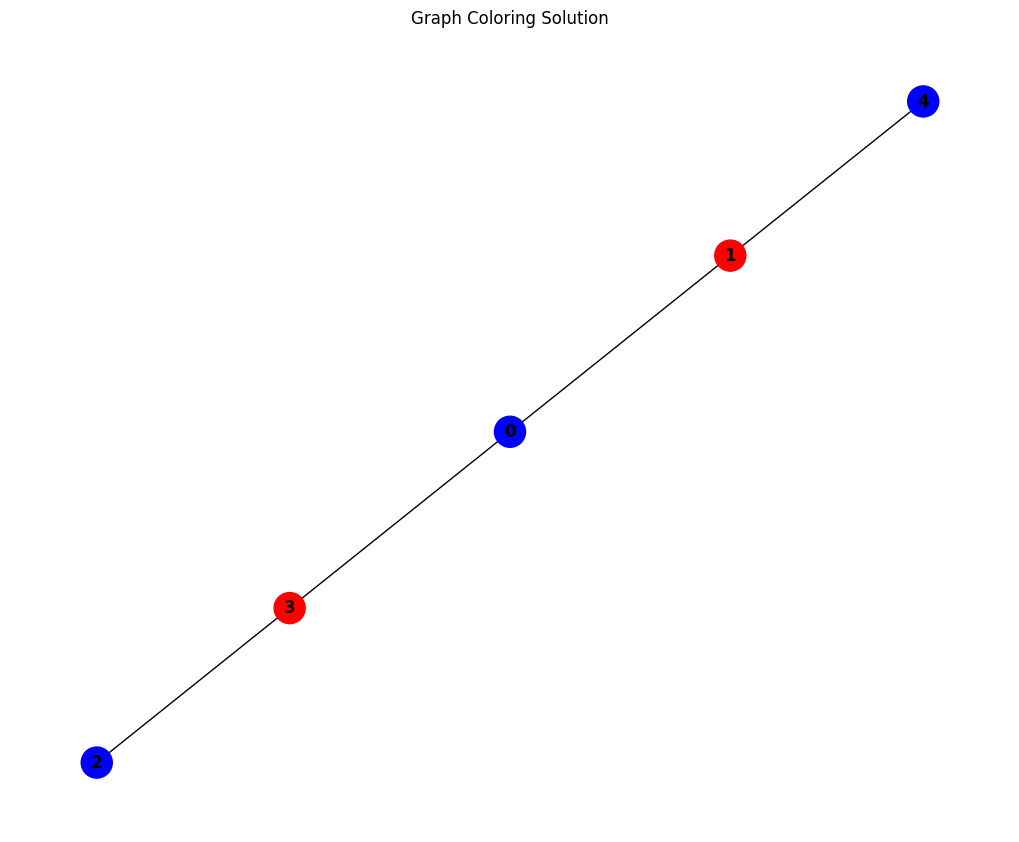

In [8]:
def run_dsb_for_best_result(adj_matrix, num_colors, R = 100, max_iter=20000, dt=0.05, A=1.0, alpha_init=0.5, alpha_scale=0.999):
    best_coloring = None
    lowest_final_energy = float('inf')
    
    for _ in range(R):
        coloring, energy_history = discrete_simulated_bifurcation(
            adj_matrix, 
            num_colors, 
            max_iter=max_iter, 
            dt=dt, 
            A=A, 
            alpha_init=alpha_init,
            alpha_scale=alpha_scale
        )
        
        if energy_history[-1] < lowest_final_energy:
            lowest_final_energy = energy_history[-1]
            best_coloring = coloring
    
    return best_coloring, energy_history

coloring, energy_history = run_dsb_for_best_result(adj_matrix, num_colors, 10, max_iter=20000, dt=0.05, A=1.0, alpha_init=0.5, alpha_scale=0.999)

# Check if solution is valid
is_valid = is_valid_coloring(adj_matrix, coloring)

# Print results
print(f"Final energy: {energy_history[-1]:.4f}")
print(f"Is valid coloring: {is_valid}")
# print("Coloring matrix:")
# print(coloring)

# Convert coloring to node labels
node_labels = []
for i in range(len(adj_matrix)):
    color_idx = np.argmax(coloring[i, :])
    node_labels.append(f"Node {i}: Color {color_idx}")

print("\nNode colorings:")
for label in node_labels:
    print(label)

# Plot energy history
plt.figure(figsize=(10, 6))
plt.plot(energy_history)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy History during Optimization')
plt.grid(True)
plt.show()

# Visualize the graph coloring
visualize_graph_coloring(adj_matrix, coloring)